# Task 1 (3 points)

Generate a toy dataset for the "XOR" problem:

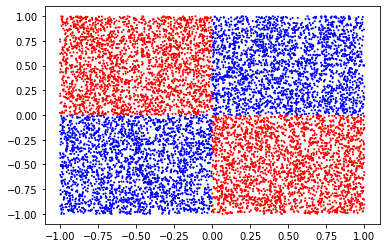

i.e. where the two features are distributed **uniformly** in $[-1, 1]$, and the target is $y = (x_0 >= 0) \text{ XOR } (x_1 >= 0)$.

Let the total number of points in the dataset be $N=10000$.

Fit a `sklearn.tree.DecisionTreeClassifier` on this data. Find a minimal `max_depth` value that results in train accuracy $>0.99$.

For each value of `max_depth` from 1 to the value found above, plot the data with the decision boundary for the obtained model. (*Hint: use `s=1` argument to `plt.scatter` to be able to see anything behind the data points.*)

For the model with train accuracy $>0.99$ use `sklearn.tree.plot_tree` to observe the tree structure.

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

In [31]:
from sklearn.metrics import accuracy_score
# Немного тактических заимствований
def plot_decision_surface(
                  clf, X, y,
                  nx=200, ny=100,
                  cmap='bwr',
                  alpha=0.6,
        ):
    """
    Plot the decision boundary of clf on X and y, visualize training points
    """

    # Define the grid
    x_top_left = X.min(axis=0) - 0.25
    x_bottom_right = X.max(axis=0) + 0.25
    grid_x0, grid_x1 = np.meshgrid(
         np.linspace(x_top_left[0], x_bottom_right[0], ny),
         np.linspace(x_top_left[1], x_bottom_right[1], nx)
      )

    # Calculate predictions on the grid
    y_pred_grid = clf.predict(
                        np.stack(
                              [
                                grid_x0.ravel(),
                                grid_x1.ravel()
                              ],
                              axis=1
                            )
                      ).reshape(grid_x1.shape)

    # Find optimal contour levels and make a filled
    # contour plot of predictions
    labels = np.sort(np.unique(y))
    labels = np.concatenate([[labels[0] - 1],
                             labels,
                             [labels[-1] + 1]])
    medians = (labels[1:] + labels[:-1]) / 2
    plt.contourf(grid_x0, grid_x1, y_pred_grid, cmap=cmap, alpha=alpha,
                 levels=medians)

    # Scatter data points on top of the plot,
    # with different styles for correct and wrong
    # predictions
    y_pred = clf.predict(X)
    plt.scatter(*X[y_pred==y].T, c=y[y_pred==y],
                marker='o', cmap=cmap, s=10, label='correct')
    plt.scatter(*X[y_pred!=y].T, c=y[y_pred!=y],
                marker='x', cmap=cmap, s=50, label='errors')

    # Dummy plot call to print the accuracy in the legend.
    plt.plot([], [], ' ',
             label='Accuracy = {:.3f}'.format(accuracy_score(y, y_pred)))

    plt.legend(loc='best')

In [2]:
N = 10000

x0 = np.random.uniform(-1, 1, N)
x1 = np.random.uniform(-1, 1, N)

y = (x0 >= 0) ^ (x1 >= 0)

data = np.column_stack((x0, x1, y))

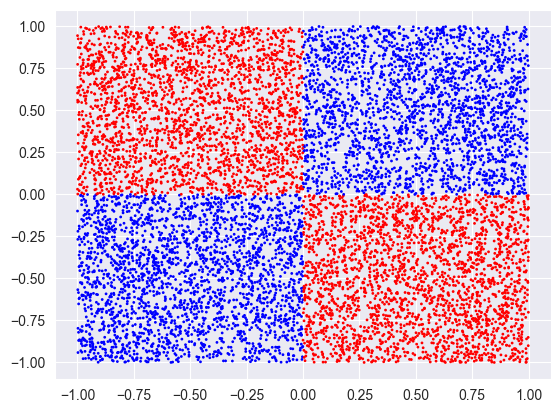

In [19]:
plt.scatter(data[:,0], data[:,1], c=data[:,2], cmap='bwr', s=1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data[:,0:2], data[:,2], test_size=0.2) # По заданию вообще тест не нужен, но пусть будет

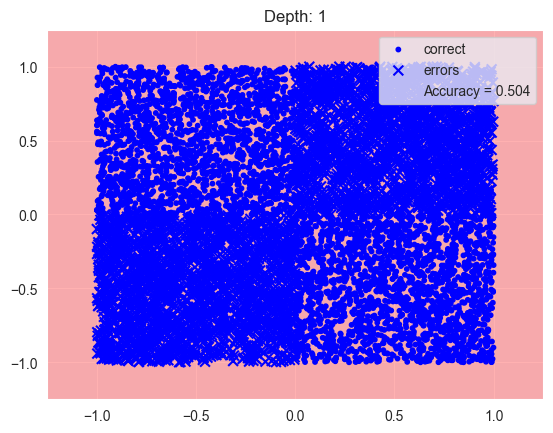

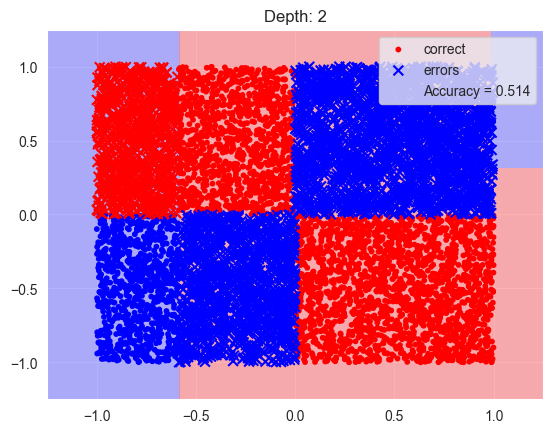

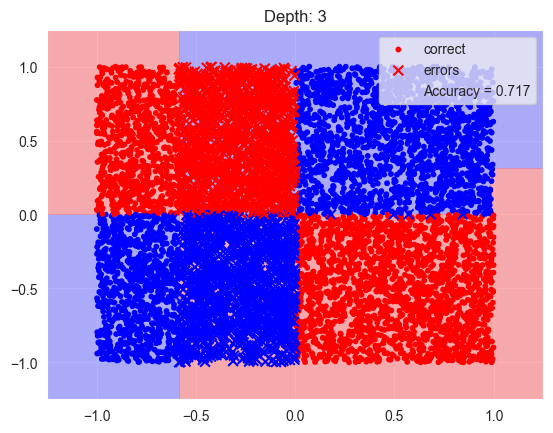

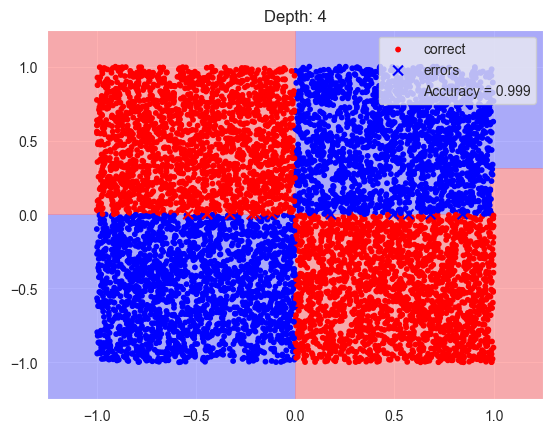

In [36]:
for depth in range(1, 5):
    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(X_train, y_train)
    plot_decision_surface(tree, X_train, y_train)
    plt.title(f'Depth: {depth}')
    plt.show()

нужная глубина 4

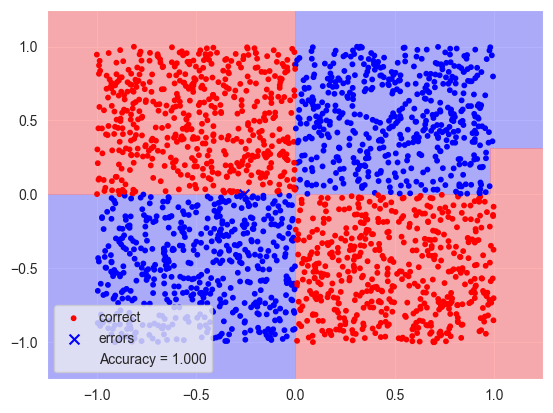

In [37]:
plot_decision_surface(tree, X_test, y_test) # почему бы и не посмотреть на тест

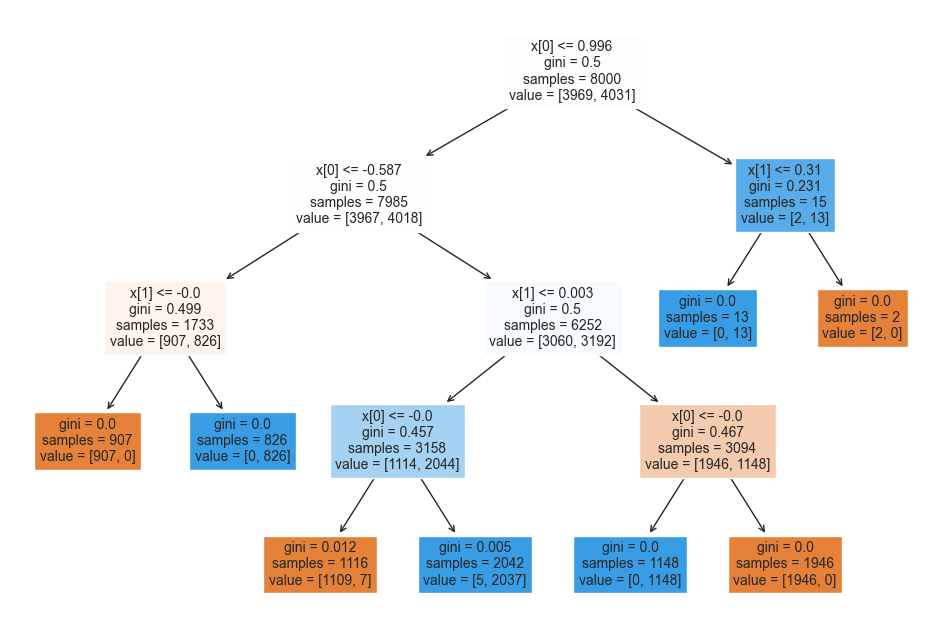

In [40]:
plt.figure(figsize=(12, 8), dpi=100)
plot_tree(tree, max_depth=4, fontsize=10, filled=True)
plt.show()

# Task 2 (3 points)

Consider the following dataset:

In [165]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
print(data.DESCR)

X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target_names[data.target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

print(X_train.iloc[:5])
print(y_train[:5])



.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

Build a `sklearn.tree.DecisionTreeClassifier` to maximize the test ROC AUC score.

When predicting cancer, it's much more dangerous to have a false negative prediction rather than false positive. Try to find the best tree (in terms of test ROC AUC) where the labels are re-weighted with the `class_weight={'malignant' : 2., 'benign' : 1.}` argument provided to the `DecisionTreeClassifier` constructor.

Plot test ROC curves for the two best models you found on the same plot.

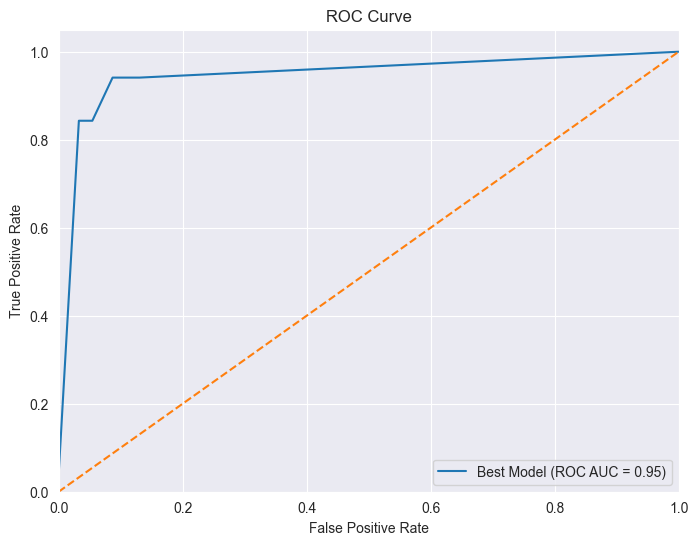

In [177]:
class_weights = {'malignant': 2.0, 'benign': 1.0}

best_roc_auc = -1
best_model = None

for max_depth in range(1, 11):
    clf = DecisionTreeClassifier(max_depth=max_depth, class_weight=class_weights, random_state=42)
    clf.fit(X_train, y_train)

    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model = clf

y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best, pos_label='malignant')
roc_auc_best = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Best Model (ROC AUC = {roc_auc_best:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

##And now...
Your should implement "fit" method in our tree class.
It have to set the corresponding self.rule methods to all nodes.
self.rule should divide your data into 2 different branches and return corresponding indices.

Metrics and learning algorothms are up to you. Try to use
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html    to find the optimal thresholds.

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.optimize import minimize_scalar

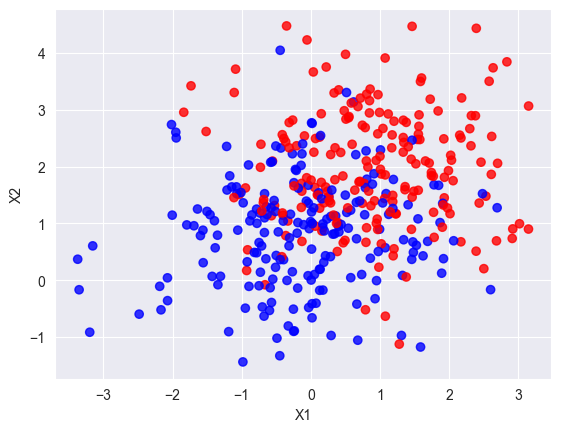

In [44]:
from sklearn.datasets import make_blobs

X_toy, y_toy = make_blobs(n_samples=400,
                          centers=[[0., 1.], [1., 2.]],
                          random_state=14)

plt.scatter(X_toy[:, 0], X_toy[:, 1], c=y_toy, alpha=0.8, cmap='bwr')
plt.xlabel('X1'), plt.ylabel('X2');

X_toy_train, X_toy_test, y_toy_train, y_toy_test = \
    train_test_split(X_toy, y_toy, test_size=0.25)

In [60]:
np.unique(y_toy, return_counts=True)[1] / np.unique(y_toy, return_counts=True)[1].sum()

array([0.5, 0.5])

In [179]:
max_tree_depth = 2

class Tree:
    def __init__(self, data=None, left=None, right=None, prediction=0, level=0, criterion='gini'):
        self.data = data
        self.left  = left
        self.right = right
        self.rule= lambda x: print("Try to run fit first")
        self.prediction = prediction
        self.level = level
        self.criterion = criterion
        self.samples = 0

    def __str__(self):
        return str(self.data)

    def is_leaf(self):
        if self.left is None and self.right is None:
            return True
        return False

    def predict(self, some_data, indices=None, predictions=None):

        predictions = np.full((some_data.shape[0]), 2) if predictions is None else predictions
        indices = np.arange(some_data.shape[0]) if indices is None else indices
        if self.is_leaf():
            if len(indices) > 0:
                predictions[indices] = self.prediction

        else:
            left_inds, right_inds = self.rule(some_data, indices)
            self.left.predict(some_data, indices=left_inds, predictions=predictions)
            self.right.predict(some_data, indices=right_inds, predictions=predictions)
        if self.level==0:
            return predictions

    def fit(self, X, y):
        #/*YOR CODE HERE*/#

        if self.level>=max_tree_depth:
            return self
        if self.level == 0:
            self.samples = len(y)

        self.left = Tree(level=self.level+1, prediction=0)
        self.right = Tree(level=self.level+1, prediction=1)

        def calculate_impurity(y, criterion=self.criterion):
            classes_counts = np.unique(y, return_counts=True)[1]
            probs = classes_counts / classes_counts.sum()

            if criterion == 'entropy':
                return - np.sum(probs * np.log(probs))
            if criterion == 'gini':
                return 1 - np.sum(np.square(probs))
            raise ValueError('Not supported criterion! Use only Gini or Entropy')

        def objective_function(threshold, feature_index, X, y):
            left_indices = X[:, feature_index] < threshold
            right_indices = X[:, feature_index] >= threshold

            left_impurity = calculate_impurity(y[left_indices])
            right_impurity = calculate_impurity(y[right_indices])

            weighted_impurity = (left_impurity * len(y[left_indices]) + right_impurity * len(y[right_indices])) / len(y)
            return weighted_impurity

        best_threshold = None
        best_feature = None
        best_impurity = float('inf')

        for feature_index in range(X.shape[1]):
            result = minimize_scalar(objective_function, args=(feature_index, X, y))
            threshold = result.x
            impurity = result.fun

            if impurity < best_impurity:
                best_impurity = impurity
                best_feature = feature_index
                best_threshold = threshold

        if best_feature is not None:
            self.feature_index = best_feature
            self.threshold = best_threshold
            self.impurity = best_impurity


            left_indices = X[:, best_feature] < best_threshold
            right_indices = X[:, best_feature] >= best_threshold

            self.rule = lambda x, indices: (indices[x[indices][:, self.feature_index] < self.threshold], indices[~(x[indices][:, self.feature_index] < self.threshold)])

            self.left.fit(X[left_indices], y[left_indices])
            self.right.fit(X[right_indices], y[right_indices])

            self.left.samples = len(y[left_indices])
            self.right.samples = len(y[right_indices])

        return self


        def node_rule(in_X):
            return in_X[:, np.random.randint(0, 2)] >= 0

        def rule_func(in_X, indices):
            after_rule = node_rule(in_X[indices])
#             print(after_rule)
            return indices[after_rule==False], indices[after_rule==True]

        self.rule = rule_func

        left_inds, right_inds = self.rule(X, np.arange(X.shape[0]))

        self.left.fit(X[left_inds], y[left_inds])
        self.right.fit(X[right_inds], y[right_inds])
#         return self

In [180]:
tree = Tree(criterion='gini')
tree.fit(X_toy_train, y_toy_train)
my_preds = tree.predict(X_toy_test)
print(accuracy_score(y_toy_test, my_preds))

0.68


In [212]:
# print(f'Criterion = {tree.criterion}')
print(f'x[{tree.feature_index}] <= {round(tree.threshold, 3)}, {tree.criterion} = {round(tree.impurity, 3)}, samples = {tree.samples}'.center(100))
print(r' /                          \ '.center(100))
print(f'x[{tree.left.feature_index}] <= {round(tree.left.threshold, 3)}, {tree.left.criterion} = {round(tree.left.impurity, 3)}, samples = {tree.left.samples} --- x[{tree.right.feature_index}] <= {round(tree.right.threshold, 3)}, {tree.right.criterion} = {round(tree.right.impurity, 3)}, samples = {tree.right.samples}'.center(100))
print(r'/            \                              /             \ '.center(100))
print(f'samples = {tree.left.left.samples} --- samples = {tree.left.right.samples}     -----     samples = {tree.right.left.samples} --- samples = {tree.right.right.samples}'.center(100))
# print(f'Left: Param[{tree.left.left.feature_index}] <= {tree.left.left.threshold} --- Right: Param[{tree.right.feature_index}] <= {tree.right.threshold}')

                             x[1] <= 1.131, gini = 0.404, samples = 300                             
                                    /                          \                                    
     x[0] <= 0.343, gini = 0.284, samples = 120 --- x[0] <= 0.077, gini = 0.372, samples = 180      
                    /            \                              /             \                     
             samples = 74 --- samples = 46     -----     samples = 63 --- samples = 117             


In [106]:
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_toy_train, y_toy_train)
my_preds = tree.predict(X_toy_test)
print(accuracy_score(y_toy_test, my_preds))

0.73


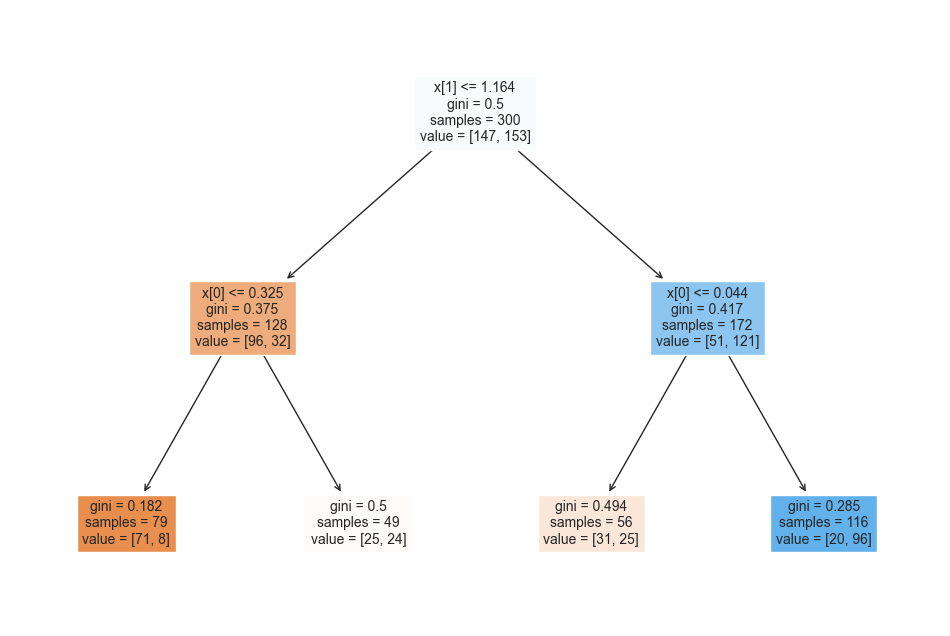

In [108]:
plt.figure(figsize=(12, 8), dpi=100)
plot_tree(tree, max_depth=2, fontsize=10, filled=True)
plt.show()

видим, что разбивает примерно одинаково, но всё же не дотягивает до библиотечной реализации